# Imports

In [5]:
# imports
import os, sys

# filter filenames for .nii
import glob

# simple itk
import SimpleITK as sitk
import sitk_gui

# segmentation, viz fns
from helpers import seg2mask, viz_objs, viz_axis

# numpy
import numpy as np

In [1]:
# imports
import os, sys

# filter for .nii
import glob

# simple itk
import SimpleITK as sitk
import sitk_gui

# numpy
import numpy as np
import nibabel as nib

# viz
#import neurite as ne
import matplotlib
import matplotlib.pyplot as plt

# segmentation obj to binary np mask 
from helpers import seg2mask
#import nilearn as nil

from nibabel.affines import apply_affine
from scipy.spatial   import ConvexHull, Delaunay

import meshio

# Helper Fns

## Seg2mask

Convert segmentation object to numpy binary mask

In [2]:
def seg2mask(image_path, segmentation_path):

  # import the .nii object
  dicom_img = nib.load(image_path)

  # import the segmentation mesh
  segmentation_mesh = meshio.read(segmentation_path)

  # Compute Delaunay triangulation of points.
  tri = Delaunay(segmentation_mesh.points)

  # define the voxel - realworld mappings 
  voxel_to_realworld_transform = dicom_img.affine
  realworld_to_voxel_transform = np.linalg.inv(voxel_to_realworld_transform)

  # initialize numpy arrays
  dicom_img_numpy_array = np.array(dicom_img.get_fdata())
  binary_segmentation_mask = np.zeros_like(dicom_img_numpy_array, dtype=np.bool_)

  # if you want to spot test a single slice, set the range to "range(80, dicom.shape[0])" this is a slice in the middle of the
  # MRI image which should be segmented. Then, uncomment the show_slices line to see the MRI and the segmentation

  # for readability
  shape0, shape1, shape2 = dicom_img_numpy_array.shape

  # from SO: https://stackoverflow.com/questions/12864445/how-to-convert-the-output-of-meshgrid-to-the-corresponding-array-of-points
  # equiv: np.array([(i,j,k) for i in range(shape0) for j in range(shape1) for k in range(shape2)])
  #voxel_location_array = np.array(np.meshgrid(range(shape0), range(shape1), range(shape2), indexing='ij')).T.reshape(-1, 3)[:,[2,1,0]]
  voxel_location_array = np.indices((shape2, shape1, shape0)).T.reshape(-1,3)[:,[2,1,0]]
  realworld_location_array = apply_affine(voxel_to_realworld_transform, voxel_location_array)
  binary_segmentation_mask = (tri.find_simplex(realworld_location_array) >= 0).reshape(shape0, shape1, shape2)

  return dicom_img_numpy_array, binary_segmentation_mask

## Viz multi-axes

In [3]:
# Vz fns

def get_mid_idx(vol, ax): return vol.shape[ax]//2
def get_mid_idxs(vol): return [get_mid_idx(vol, ax=i) for i in (0, 1, 2)]


# ne.plot.slices(slices, titles=titles, grid=[2,3], \
#                cmaps=['gray'], do_colorbars=True)

# Viz slices from all 3 axes. 
# Input: 3-elem list, where list[i] = slices to display from axis i
def viz_multi_axes(vol, axes_idxs=[None, None, None], do_plot = False, **kwargs):
  slices, titles = [], []
  for ax in (0, 1, 2):
    idxs = axes_idxs[ax]
    if idxs is None:          idxs = get_mid_idx(vol, ax)
    if isinstance(idxs, int): idxs = [idxs]

    titles += [f"Ax {ax}, slice {i}"    for i in idxs]
    slices += [np.take(vol, i, axis=ax) for i in idxs]

  # plot the slices
  if do_plot: ne.plot.slices(slices, titles=titles, **kwargs)

  return slices, titles

def viz_objs(*objs, do_plot = True, **kwargs):
  # return flattened slices, titles
  slices, titles = zip(*[viz_multi_axes(sitk.GetArrayFromImage(o)) for o in objs])
  flat_slices = [s for ax in slices for s in ax]
  flat_titles = [t for ax in titles for t in ax]

  # plot the slices
  if do_plot: ne.plot.slices(flat_slices, titles=flat_titles, **kwargs)

  return flat_slices, flat_titles

## Viz axis (w/ overlay)

In [4]:
# viz segm
from matplotlib import pyplot as plt
from matplotlib import gridspec

# identity "do nothing" function
def id(x): return x

# viz slices from a single axis, w/ optional mask overlay
def viz_axis(np_arr, slices, fixed_axis, bin_mask_arr=None, bin_mask_arr2 = None, **kwargs):
  n_slices = len(slices)
  
  # set default options if not given
  options = {
    "grid": (1, n_slices),
    "wspace": 0.0,
    "hspace": 0.0,
    "fig_mult": 1,
    "cmap0": "rainbow",
    "cmap1": matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "yellow"]),
    "cmap2": matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "blue"]),
    "alpha1": 0.7,
    "alpha2": 0.7,
    "axis_fn": id,
  }

  options.update(kwargs)

  axis_fn      = options["axis_fn"]
  nrows, ncols = options["grid"]
  fig_mult     = options["fig_mult"]

  # from SO: https://stackoverflow.com/questions/41071947/how-to-remove-the-space-between-subplots-in-matplotlib-pyplot
  
  fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
  gs  = gridspec.GridSpec(nrows, ncols,
    wspace=options["wspace"], hspace=options["hspace"], 
    top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
    left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 

  # plot each slice idx
  index = 0
  for row in range(nrows):
    for col in range(ncols):
      ax = plt.subplot(gs[row,col])
      ax.set_title(f"Slice {slices[index]}")
      
      # show ticks only on 1st im
      if index != 0:
        ax.set_xticks([])
        ax.set_yticks([])

      # in case slices in grid > n_slices
      if index < n_slices: 
        ax.imshow(axis_fn(np.take(np_arr, slices[index], fixed_axis)), cmap=options["cmap0"])
        
        # overlay binary mask if provided
        if bin_mask_arr is not None:
          ax.imshow(axis_fn(np.take(bin_mask_arr, slices[index], fixed_axis)), cmap=options["cmap1"], alpha=options["alpha1"])

        # overlay binary mask if provided
        if bin_mask_arr2 is not None:
          ax.imshow(axis_fn(np.take(bin_mask_arr2, slices[index], fixed_axis)), cmap=options["cmap2"], alpha=options["alpha2"])

      else: 
        ax.imshow(np.full((1,1,3), 255)) # show default white image of size 1x1
      
      index += 1
  
  plt.show()
  # return plt

## Misc

In [5]:
# round all floats in a tuple to 3 decimal places
def round_tuple(t): return tuple(round(x,3) for x in t)

# returns range obj as list
def lrange(a,b): return list(range(a,b))

## Np/SITK conv

In [7]:
# see which slices contain ROI
def get_roi_range(bin_mask_arr, axis):
  slices = np.unique(np.nonzero(bin_mask_arr)[axis])
  return min(slices), max(slices)

# sitk obj and np array have different index conventions
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)

# numpy mask arr into sitk obj
def np2sitk(mask_arr, sitk_image):
  # swap axes for sitk
  obj = sitk.GetImageFromArray(np.swapaxes(mask_arr, 0, 2))
  obj.SetOrigin(sitk_image.GetOrigin())
  obj.SetSpacing(sitk_image.GetSpacing())   
  obj.SetDirection(sitk_image.GetDirection())
  return obj

# Load Data

In [10]:
PROJ_PATH = "."

In [11]:
# Load train data
mr_train_path = f"{PROJ_PATH}/train_data/train_data"

# Folders containing MR train data
train_folders = os.listdir(mr_train_path)
print(f"Train data folders: {train_folders}")

# make a dictionary of key = train folder, value = (segm obj, nii file)
train_data_dict = {}
for folder in train_folders:
  segm_obj_path = os.path.join(mr_train_path, folder, "Segmentation.obj")

  mp_path      = os.path.join(mr_train_path, folder, "MP-RAGE")
  folder1_path = os.path.join(mp_path, os.listdir(mp_path)[0])
  folder2_path = os.path.join(folder1_path, os.listdir(folder1_path)[0])
  nii_path     = glob.glob(f"{folder2_path}/*.nii")[0] #os.path.join(folder2_path, os.listdir(folder2_path)[0])
  train_data_dict[folder] = (segm_obj_path, nii_path)

Train data folders: ['50455', '50458', '50461', '50456', '50463', '50459', '50457', '50462', '50460', '50464']


In [12]:
train_data_dict

{'50455': ('./train_data/train_data/50455/Segmentation.obj',
  './train_data/train_data/50455/MP-RAGE/2000-01-01_00_00_00.0/S165455/ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii'),
 '50458': ('./train_data/train_data/50458/Segmentation.obj',
  './train_data/train_data/50458/MP-RAGE/2000-01-01_00_00_00.0/S165212/ABIDE_50458_MRI_MP-RAGE_br_raw_20120830215600956_S165212_I329222.nii'),
 '50461': ('./train_data/train_data/50461/Segmentation.obj',
  './train_data/train_data/50461/MP-RAGE/2000-01-01_00_00_00.0/S165203/ABIDE_50461_MRI_MP-RAGE_br_raw_20120830215105276_S165203_I329213.nii'),
 '50456': ('./train_data/train_data/50456/Segmentation.obj',
  './train_data/train_data/50456/MP-RAGE/2000-01-01_00_00_00.0/S164657/ABIDE_50456_MRI_MP-RAGE_br_raw_20120830174547173_S164657_I328667.nii'),
 '50463': ('./train_data/train_data/50463/Segmentation.obj',
  './train_data/train_data/50463/MP-RAGE/2000-01-01_00_00_00.0/S165068/ABIDE_50463_MRI_MP-RAGE_br_raw_20120830202814958_S16

In [13]:
# Get path to MR file

moving_folder = "50455"
segm_path, moving_mr_file = train_data_dict[moving_folder]

print(f"Folder: {moving_folder}, MR nii path: {os.path.basename(moving_mr_file)}.")

# compile MR obj from nii file using Simple ITK reader
moving_obj        = sitk.ReadImage(moving_mr_file)

print("#"*10, f"Moving", "#"*10)
print(f"mr vol shape: {moving_obj.GetSize()}")
print(f"mr vol spacing: {round_tuple(moving_obj.GetSpacing())}")
print(f"mr orientation: {round_tuple(moving_obj.GetDirection())}")

# get segm as np binary mask arr
moving_mr_arr, moving_mask_arr = seg2mask(moving_mr_file, segm_path)

Folder: 50455, MR nii path: ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii.
########## Moving ##########
mr vol shape: (160, 480, 512)
mr vol spacing: (1.2, 0.5, 0.5)
mr orientation: (0.999, 0.023, -0.024, 0.023, -1.0, -0.001, 0.024, 0.0, 1.0)


In [14]:
# Get path to MR file

fixed_folder = "50456"
fixed_segm_path, fixed_mr_file = train_data_dict[fixed_folder]

print(f"Folder: {fixed_folder}, MR nii path: {os.path.basename(fixed_mr_file)}.")

# compile MR obj from nii file using Simple ITK reader
fixed_obj        = sitk.ReadImage(fixed_mr_file)

print("#"*10, f"Fixed", "#"*10)
print(f"mr vol shape: {fixed_obj.GetSize()}")
print(f"mr vol spacing: {round_tuple(fixed_obj.GetSpacing())}")
print(f"mr orientation: {round_tuple(fixed_obj.GetDirection())}")

# get segm as np binary mask arr
fixed_mr_arr, fixed_mask_arr = seg2mask(fixed_mr_file, fixed_segm_path)

Folder: 50456, MR nii path: ABIDE_50456_MRI_MP-RAGE_br_raw_20120830174547173_S164657_I328667.nii.
########## Fixed ##########
mr vol shape: (160, 480, 512)
mr vol spacing: (1.2, 0.5, 0.5)
mr orientation: (1.0, -0.026, 0.0, -0.026, -1.0, 0.0, 0.0, 0.0, 1.0)


In [40]:
print(f"ROI non-zero range: ", get_roi_range(fixed_mask_arr, axis=0))
print(f"ROI non-zero range: ", get_roi_range(moving_mask_arr, axis=0))

ROI non-zero range:  (65, 90)
ROI non-zero range:  (65, 93)


In [15]:
resultImage = sitk.Elastix(fixed_obj, \
                           moving_obj, \
                           "translation")

In [16]:
resultImage

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7ff07c263f00> >

In [18]:
result_arr = sitk.GetArrayFromImage(resultImage)

In [19]:
np_result_arr = sitk2np(resultImage)

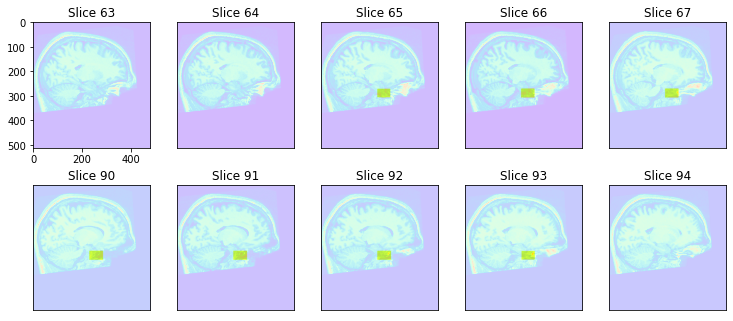

In [21]:
viz_axis(np_result_arr, bin_mask_arr=moving_mask_arr, 
        slices=lrange(63, 68) + lrange(90,95), fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [45]:
import numpy as np

In [48]:
print(np.array([1,2,3]))

[1 2 3]
